In [8]:
import torch
import torchvision.models as models
import torchvision.transforms as T
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import json
import urllib.request

In [9]:
# ===================
# 1) Load Pretrained ResNet
# ===================
resnet = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
resnet.eval()

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 72.4MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [10]:
url = "https://pytorch.org/assets/images/dog.jpg"
!wget -q {url} -O input.jpg


# Download ImageNet class index mapping
url = "https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt"
classes = urllib.request.urlopen(url).read().decode("utf-8").splitlines()

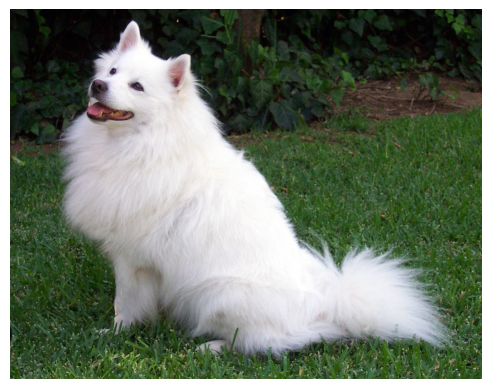

In [11]:
# visualize
img = Image.open("input.jpg")
plt.imshow(img)
plt.axis("off")
plt.show()

In [12]:
img = Image.open("input.jpg")

transform = T.Compose([
    T.Resize((224,224)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]),
])

x = transform(img).unsqueeze(0)

# Forward pass
pred = resnet(x)

prob = torch.softmax(pred, dim=1)
top_idx = prob.argmax().item()

print("Predicted index:", top_idx)
print("Predicted class:", classes[top_idx])


Predicted index: 258
Predicted class: Samoyed


Feature map size: torch.Size([64, 112, 112])


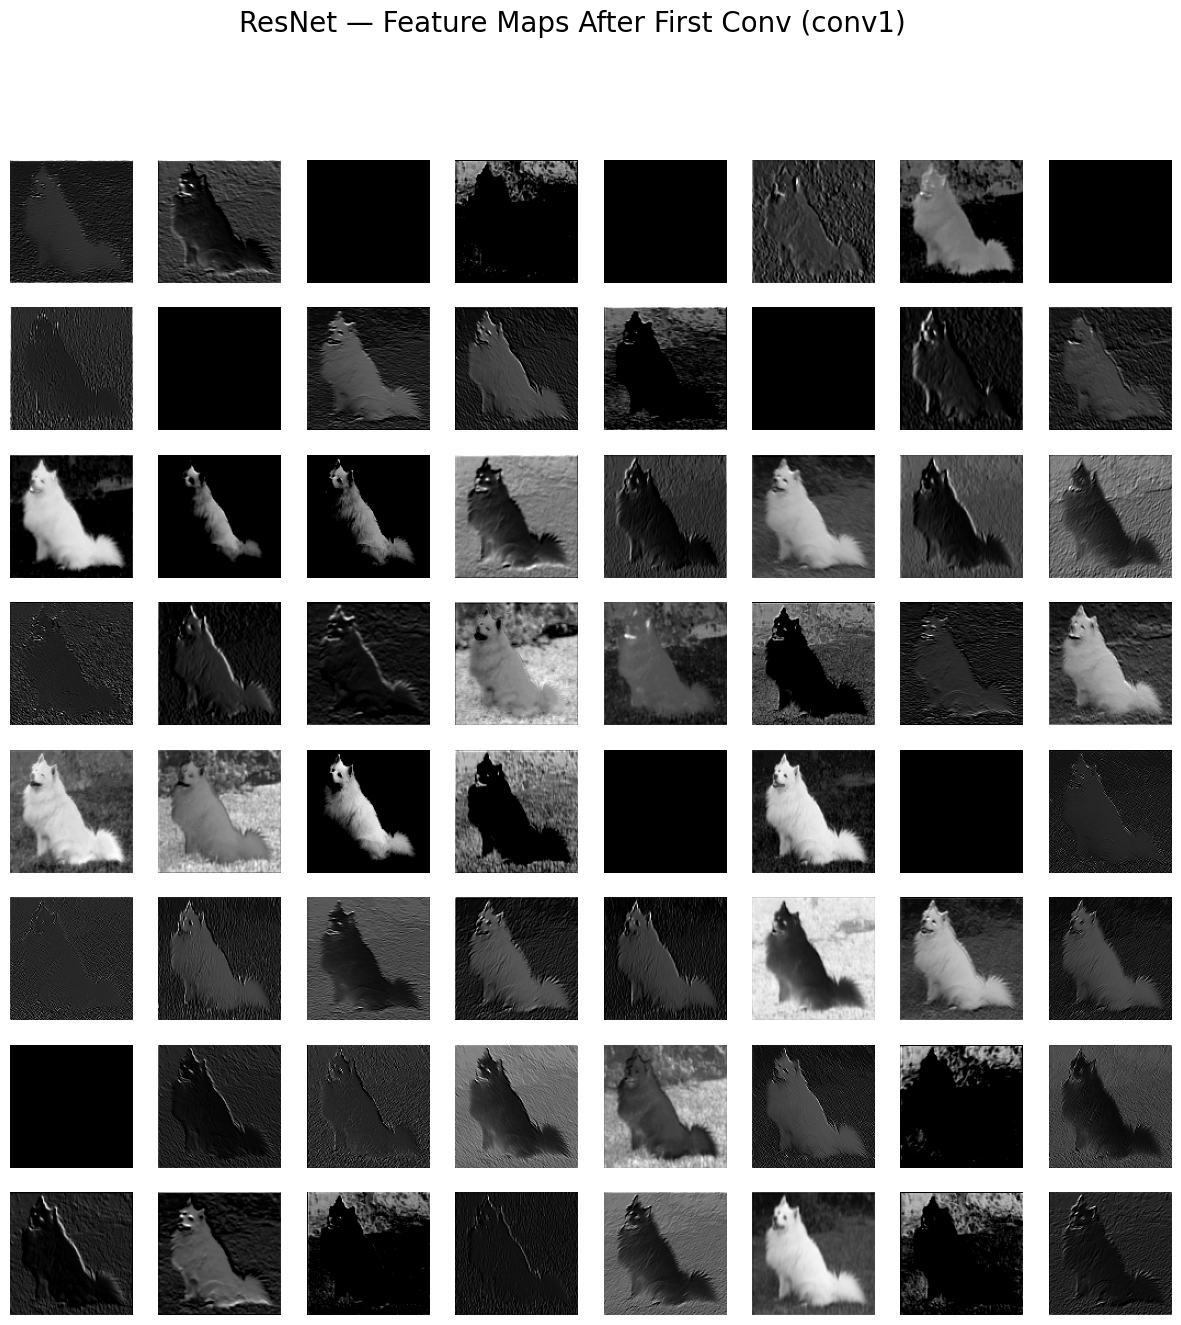

In [13]:
with torch.no_grad():
    fm = resnet.conv1(x)   # shape: [1, 64, H, W]
    fm = resnet.bn1(fm)
    fm = resnet.relu(fm)
    #fm = resnet.maxpool(fm)

# ---- Visualization ----
fm = fm.squeeze(0)  # remove batch dim → [64, H, W]

num_channels = fm.shape[0]
grid = int(np.ceil(np.sqrt(num_channels)))

plt.figure(figsize=(15,15))
for i in range(num_channels):
    plt.subplot(grid, grid, i+1)
    fmap = fm[i].cpu().numpy()
    fmap = (fmap - fmap.min()) / (fmap.max() - fmap.min() + 1e-5)
    plt.imshow(fmap, cmap="gray")
    plt.axis("off")

# print size
print("Feature map size:", fm.shape)

plt.suptitle("ResNet — Feature Maps After First Conv (conv1)", fontsize=20)
plt.show()


Feature map shape from layer1[0].conv1: torch.Size([64, 56, 56])


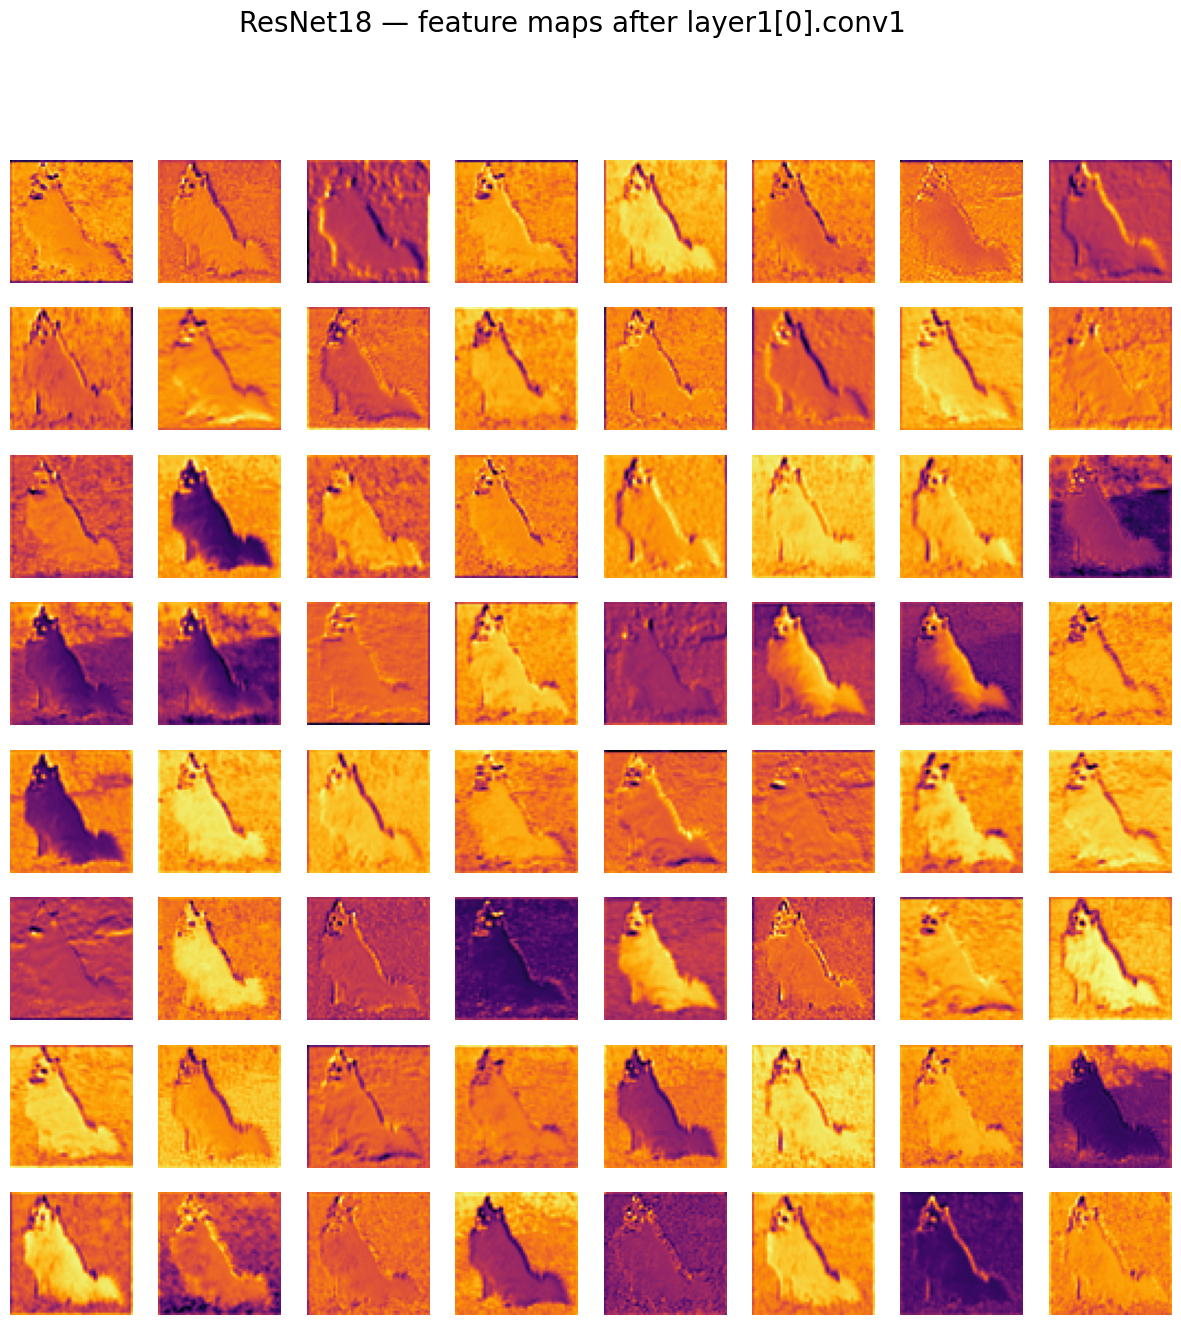

In [15]:
import torch
import matplotlib.pyplot as plt
import numpy as np

resnet.eval()

# ========= PARAMETERS (CHANGE THESE) ==========
L = 1     # layer number: 1, 2, 3, or 4
B = 0     # block index: 0 or 1
C = 1     # conv index: 1 or 2
# ==============================================

with torch.no_grad():

    # ---- Stem ----
    out = resnet.conv1(x)
    out = resnet.bn1(out)
    out = resnet.relu(out)
    out = resnet.maxpool(out)

    # ---- Process earlier layers fully ----
    if L > 1:
        out = resnet.layer1(out)
    if L > 2:
        out = resnet.layer2(out)
    if L > 3:
        out = resnet.layer3(out)

    # ---- We are now at input of layer L ----
    layer = getattr(resnet, f"layer{L}")

    # If B == 1, run block0 fully
    if B == 1:
        out = layer[0](out)

    # Now choose the block
    block = layer[B]

    # ---- Run conv1 if needed ----
    if C == 1:
        fm = block.conv1(out)

    elif C == 2:
        # conv2 requires passing through conv1 + bn + relu
        h = block.conv1(out)
        h = block.bn1(h)
        h = block.relu(h)
        fm = block.conv2(h)

# ---- Visualization ----
fm = fm.squeeze(0)
print(f"Feature map shape from layer{L}[{B}].conv{C}:", fm.shape)

num_channels = fm.shape[0]
grid_size = int(np.ceil(np.sqrt(num_channels)))

plt.figure(figsize=(15, 15))
for i in range(num_channels):
    plt.subplot(grid_size, grid_size, i+1)
    fmap_img = fm[i].cpu().numpy()
    fmap_img = (fmap_img - fmap_img.min()) / (fmap_img.max() - fmap_img.min() + 1e-5)
    plt.imshow(fmap_img, cmap="inferno")
    plt.axis("off")

plt.suptitle(f"ResNet18 — feature maps after layer{L}[{B}].conv{C}", fontsize=20)
plt.show()


In [ ]:
# check if the resnet is output dog for the image
img_class_pred = resnet(img)